In [2]:
import graphlab
import numpy

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Debi aislar las funciones porque parece que en el otro ipython algo metia ruido y los resultados no eran correctos.

* DATOS

In [4]:
sales = graphlab.SFrame('kc_house_data.gl/')

[INFO] 1450791293 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_FILE to C:\Users\margrami\AppData\Local\Dato\Dato Launcher\lib\site-packages\certifi\cacert.pem
1450791293 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_DIR to 
This non-commercial license of GraphLab Create is assigned to margrami221@yahoo.com and will expire on October 13, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-6476 - Server binary: C:\Users\margrami\AppData\Local\Dato\Dato Launcher\lib\site-packages\graphlab\unity_server.exe - Server log: C:\Users\margrami\AppData\Local\Temp\graphlab_server_1450791293.log.0
[INFO] GraphLab Server Version: 1.7.1


In [5]:
sales = sales.sort(['sqft_living','price'])

In [6]:
(train_valid, test) = sales.random_split(.9, seed=1)
train_valid_shuffled = graphlab.toolkits.cross_validation.shuffle(train_valid, random_seed=1)

* FUNTIONS

In [7]:
def polynomial_sframe(feature, degree):
    # assume that degree >= 1
    # initialize the SFrame:
    poly_sframe = graphlab.SFrame()
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_sframe['power_1'] = feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_sframe[str(name)] = feature.apply(lambda x: x**power)
    return poly_sframe

In [8]:
def create_segment(dico, segment, data_set):
    seg_data = data_set[dico.get(segment)[0]:dico.get(segment)[1]]   
    return seg_data

In [9]:
def excluding_segment(dico, segment, data_set):
    # ojo con la mutabilidad de python 
    # para copiar un diccionario hacer z = x.copy()
    dico2 = dico.copy()
    del dico2[segment]
    valores = dico2.values()
    new_data = data_set[valores[0][0]:valores[0][1]]
    del valores[0]
    for seg in valores:
        new_data.append(data_set[seg[0]:seg[1]]) # pega los segmentos restantes
    
    return new_data


In [45]:
def k_fold_cross_validation(k, L2, data, output_name, features_list):
    n = len(data) # 10-fold cross-validation
    kDicc={}
    mse = 0
    #Compute starting and ending indices of segment i and call 'start' and 'end'
    for i in xrange(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        # dic['key'] = value, en este caso una tupla
        kDicc[str(i)] = (start, end)
    # toda los segmentos estan en el diccionario kDicc
    for i in xrange(k):
        # Form validation set by taking a slice (start:end+1) from the data
        validation= create_segment(kDicc,str(i),data)
        #Form training set by appending slice (end+1:n) to the end of slice (0:start).
        train = excluding_segment(kDicc,str(i),data)
        # Train a linear model using training set just formed, with a given l2_penalty
        model= graphlab.linear_regression.create(train, target = 'price', features = features_list, l2_penalty = L2, 
                                                 validation_set = None, verbose = False)
        #Compute validation error using validation set just formed
        
        # predict on validation set 
        predicted = model.predict(validation)
        # compute squared error
        mse += ((predicted - validation['price'])**2).sum()
    mean_mse = mse/k
    return mean_mse

* This is something like main 

In [46]:
polySet_data_shuffled = polynomial_sframe(train_valid_shuffled['sqft_living'], 15)
features_list = polySet_data_shuffled.column_names()
polySet_data_shuffled['price'] = train_valid_shuffled['price']

In [47]:
l2_penalty_values = numpy.logspace(1, 7, num=13)
l2_penalty_values

array([  1.00000000e+01,   3.16227766e+01,   1.00000000e+02,
         3.16227766e+02,   1.00000000e+03,   3.16227766e+03,
         1.00000000e+04,   3.16227766e+04,   1.00000000e+05,
         3.16227766e+05,   1.00000000e+06,   3.16227766e+06,
         1.00000000e+07])

we consider "leave one out" (LOO) cross validation, which one can show approximates average mean square error (MSE). 
As a result, choosing lambda to minimize the LOO error is 
equivalent to choosing lambda to minimize an approximation to average MSE.


In [51]:
l2_penalty_values = numpy.logspace(1, 7, num=13)
vector_mse = []
for l2_penalty in l2_penalty_values:
    vector_mse.append(k_fold_cross_validation(10, l2_penalty, polySet_data_shuffled, polySet_data_shuffled['price'], features_list))
selected = vector_mse.index(min(vector_mse))
print "Best performant Lambda :", l2_penalty_values[selected]
    


Best performant Lambda : 316.227766017


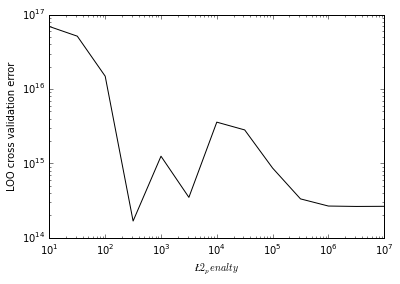

In [52]:
# Plot the l2_penalty values in the x axis and the cross-validation error in the y axis.
# Using plt.xscale('log') will make your plot more intuitive.
plt.plot(l2_penalty_values,vector_mse,'k-')
plt.xlabel('$\L2_penalty$')
plt.ylabel('LOO cross validation error')
plt.xscale('log')
plt.yscale('log')


* Una vez el Lambda encontrado, entrenar el modelo con el train data y el Lambda encontrado y predecir los valores 
* con los datos de test 

In [53]:
model_selected = graphlab.linear_regression.create (polySet_data_shuffled, target = 'price', features = features_list, l2_penalty = l2_penalty_values[selected], 
                                                 validation_set = None, verbose = False)

In [58]:
polySet_test = polynomial_sframe(test['sqft_living'], 15)
features_list = polySet_test.column_names()
polySet_test['price'] = test['price']
predict = model_selected.predict(polySet_test) 
mse = ((predict - polySet_test['price'])**2).sum()
print "Squared error test_set con selected lambda :", mse

Squared error test_set con selected lambda : 1.27643873739e+14


In [55]:
# Sort in order to draw the curve
test = test.sort(['sqft_living', 'price'])
polySet_test = polySet_test.sort(['power_1', 'price'])

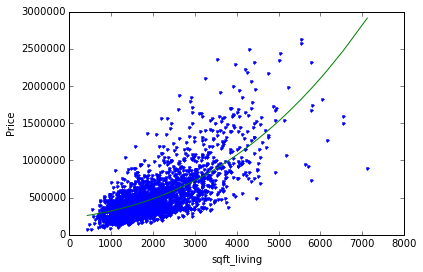

In [57]:
plt.plot(test['sqft_living'], test['price'],'.',
        polySet_test['power_1'], model_selected.predict(polySet_test),'-' )
plt.xlabel('sqft_living')
plt.ylabel('Price')